In [1]:
import os
import mlflow
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy

from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor

from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

In [2]:
df = pd.read_pickle('../data/clean_data.pkl').sample(frac = 0.1, random_state = 2)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2285 entries, 1626 to 22026
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Date           2285 non-null   object  
 1   Gender         2285 non-null   category
 2   Annual Income  2285 non-null   float32 
 3   Dealer_Name    2285 non-null   category
 4   Company        2285 non-null   category
 5   Model          2285 non-null   category
 6   Color          2285 non-null   category
 7   Price ($)      2285 non-null   float32 
 8   Dealer_No      2285 non-null   object  
 9   Body Style     2285 non-null   category
 10  Dealer_Region  2285 non-null   category
 11  Config         2285 non-null   category
 12  Month          2285 non-null   int32   
 13  Year           2285 non-null   int32   
 14  Price/Income   2285 non-null   float32 
 15  norm_Income    2285 non-null   float32 
 16  norm_Price     2285 non-null   float32 
dtypes: category(8), float32(5), int32(

In [3]:
df = df.rename(columns={'Price ($)': 'target'})
df = df.drop(columns = ['Date', 'Month'])

In [4]:
df

,Gender,Annual Income,Dealer_Name,Company,Model,Color,target,Dealer_No,Body Style,Dealer_Region,Config,Year,Price/Income,norm_Income,norm_Price
1626,Male,900000.0,Iceberg Rentals,Mercury,Mercury Sable,Red,39000.0,53546-9427,Sedan,Janesville,DoubleÂ Overhead Camshaft Auto,2022,0.043333,0.079529,0.440191
723,Female,13500.0,Race Car Help,Toyota,Toyota Land Cruiser,Black,21000.0,78758-7841,SUV,Austin,DoubleÂ Overhead Camshaft Auto,2022,1.555556,0.000306,0.224880
19756,Female,620000.0,Clay Johnson Auto Sales,Dodge,Dodge Intrepid,Black,11001.0,78758-7841,Sedan,Austin,Overhead Camshaft Manual,2023,0.017744,0.054506,0.105275
20920,Male,13500.0,McKinney Dodge Chrysler Jeep,Audi,Audi A6,Pale White,24000.0,85257-3102,SUV,Scottsdale,Overhead Camshaft Manual,2023,1.777778,0.000306,0.260766
10420,Female,13500.0,New Castle Ford Lincoln Mercury,Nissan,Nissan Altima,Pale White,21001.0,60504-7114,Hatchback,Aurora,DoubleÂ Overhead Camshaft Auto,2022,1.555630,0.000306,0.224892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17526,Male,657500.0,Ryder Truck Rental and Leasing,Cadillac,Cadillac Eldorado,Black,29500.0,06457-3834,Passenger,Middletown,Overhead Camshaft Manual,2023,0.044867,0.057857,0.326555
10550,Male,903000.0,Suburban Ford,Lexus,Lexus LS400,Pale White,27001.0,53546-9427,Sedan,Janesville,DoubleÂ Overhead Camshaft Auto,2022,0.029901,0.079797,0.296663
6414,Male,981000.0,Saab-Belle Dodge,Saturn,Saturn LS,Pale White,51000.0,60504-7114,Sedan,Aurora,DoubleÂ Overhead Camshaft Auto,2022,0.051988,0.086767,0.583732
23086,Male,600000.0,Clay Johnson Auto Sales,Chrysler,Chrysler Cirrus,Red,12001.0,78758-7841,Passenger,Austin,DoubleÂ Overhead Camshaft Auto,2023,0.020002,0.052719,0.117237


In [5]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis=1), df['target'], test_size = 0.25, random_state = 2)

In [6]:
cat_features = X_train.select_dtypes(include=['category', 'object']).columns.to_list()
cat_features

['Gender',
 'Dealer_Name',
 'Company',
 'Model',
 'Color',
 'Dealer_No ',
 'Body Style',
 'Dealer_Region',
 'Config']

In [7]:
num_features = X_train.select_dtypes(include = ['number']).columns.to_list()
num_features

['Annual Income', 'Year', 'Price/Income', 'norm_Income', 'norm_Price']

In [8]:
s_scaler = StandardScaler()
l_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=99999999)
regressor = CatBoostRegressor()

In [9]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', s_scaler, num_features),  # преобразования для числовых признаков
        ('cat', l_encoder, cat_features), # преобразования для категориальных признаков
    ],
    remainder='drop' ) # Удаляем столбцы, которые не затронуты преобразования

In [10]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor), 
                           ('model', regressor)])

pipeline.fit(X_train, y_train)

Learning rate set to 0.044577
0:	learn: 13809.1569915	total: 64.5ms	remaining: 1m 4s
1:	learn: 13360.8881409	total: 72.6ms	remaining: 36.2s
2:	learn: 12884.1574913	total: 73.8ms	remaining: 24.5s
3:	learn: 12398.4071229	total: 76.1ms	remaining: 18.9s
4:	learn: 11960.2152363	total: 78.7ms	remaining: 15.7s
5:	learn: 11532.2484021	total: 84.1ms	remaining: 13.9s
6:	learn: 11096.6129748	total: 85.9ms	remaining: 12.2s
7:	learn: 10694.6695614	total: 96.7ms	remaining: 12s
8:	learn: 10311.4520848	total: 101ms	remaining: 11.2s
9:	learn: 9913.7881842	total: 106ms	remaining: 10.5s
10:	learn: 9558.4684907	total: 113ms	remaining: 10.2s
11:	learn: 9198.5806291	total: 117ms	remaining: 9.64s
12:	learn: 8879.2997198	total: 123ms	remaining: 9.33s
13:	learn: 8575.6318516	total: 127ms	remaining: 8.93s
14:	learn: 8270.4110308	total: 133ms	remaining: 8.76s
15:	learn: 7995.0992161	total: 139ms	remaining: 8.53s
16:	learn: 7693.9306953	total: 140ms	remaining: 8.08s
17:	learn: 7431.6369104	total: 151ms	remaining:

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Annual Income', 'Year',
                                                   'Price/Income',
                                                   'norm_Income',
                                                   'norm_Price']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=99999999),
                                                  ['Gender', 'Dealer_Name',
                                                   'Company', 'Model', 'Color',
                                                   'Dealer_No ', 'Body Style',
                                                   'Dealer_Region',
                                                   'Config'])])),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x74b9ea97a980>)])

In [11]:
predictions = pipeline.predict(X_test) 

metrics = {}
metrics["mae"] = mean_absolute_error(y_test, predictions)   
metrics["mape"] = mean_absolute_percentage_error(y_test, predictions)
metrics["mse"] = mean_squared_error(y_test, predictions)

metrics

{'mae': 147.92809561161928,
 'mape': 0.005636038616034008,
 'mse': 186539.68771819372}

In [12]:
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

registry_uri = f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}"
tracking_uri = f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}"

mlflow.set_tracking_uri(tracking_uri)   
mlflow.set_registry_uri(registry_uri)   

In [13]:
EXPERIMENT_NAME = "estate_project"
RUN_NAME = "baseline model"
REGISTRY_MODEL_NAME = "estate_model_rf"

In [14]:
from mlflow.models import infer_signature

signature =  infer_signature(model_input = X_train.head(5))
input_example = X_train.head(5)

/home/mainuser/my_proj/.venv_my_proj/lib/python3.10/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


In [15]:
req_file = '../requirements.txt'
art = '../comment.txt'

In [16]:
params_dict = pipeline.get_params()

In [ ]:
# Когда создаем новый эксперимент, то: 
#experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)

# Впоследствии. чтобы добавлять запуски в этот же эксепримент мы должны получить его id:
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_artifact(art)
    mlflow.log_params(params_dict)

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

/home/mainuser/my_proj/.venv_my_proj/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024/11/18 23:17:09 INFO mlflow.tracking._tracking_service.client: 🏃 View run baseline model at: http://127.0.0.1:5000/#/experiments/1/runs/f0772aeef7a743289eee4d14c13a3c29.
2024/11/18 23:17:09 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.


In [ ]:
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
mlflow.search_runs(experiment_names=[EXPERIMENT_NAME],)


,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.mse,metrics.mae,metrics.mape,params.preprocessor__cat__categories,...,params.verbose,params.preprocessor__cat__handle_unknown,params.preprocessor__num__copy,params.preprocessor__transformers,params.preprocessor__cat,tags.mlflow.user,tags.mlflow.source.type,tags.mlflow.source.name,tags.mlflow.runName,tags.mlflow.log-model.history
0,f0772aeef7a743289eee4d14c13a3c29,1,FINISHED,mlflow-artifacts:/1/f0772aeef7a743289eee4d14c1...,2024-11-18 20:17:05.360000+00:00,2024-11-18 20:17:08.991000+00:00,186539.687718,147.928096,0.005636,auto,...,False,use_encoded_value,True,"[('num', StandardScaler(), ['Annual Income', '...",OrdinalEncoder(handle_unknown='use_encoded_val...,mainuser,LOCAL,/home/mainuser/my_proj/.venv_my_proj/lib/pytho...,baseline model,"[{""run_id"": ""f0772aeef7a743289eee4d14c13a3c29""..."


In [19]:
mlflow.sklearn.autolog()

with mlflow.start_run(run_name='auto', experiment_id=experiment_id) as run:
    pipeline.fit(X_train, y_train)

2024/11/18 23:17:09 WARNING mlflow.utils.autologging_utils: MLflow sklearn autologging is known to be compatible with 0.24.1 <= scikit-learn <= 1.5.1, but the installed version is 1.5.2. If you encounter errors during autologging, try upgrading / downgrading scikit-learn to a compatible version, or try upgrading MLflow.
2024/11/18 23:17:16 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/mainuser/my_proj/.venv_my_proj/lib/python3.10/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever the

Learning rate set to 0.044577
0:	learn: 13809.1569915	total: 1.55ms	remaining: 1.54s
1:	learn: 13360.8881409	total: 2.99ms	remaining: 1.49s
2:	learn: 12884.1574913	total: 3.86ms	remaining: 1.28s
3:	learn: 12398.4071229	total: 4.7ms	remaining: 1.17s
4:	learn: 11960.2152363	total: 5.93ms	remaining: 1.18s
5:	learn: 11532.2484021	total: 7.02ms	remaining: 1.16s
6:	learn: 11096.6129748	total: 8.3ms	remaining: 1.18s
7:	learn: 10694.6695614	total: 9.3ms	remaining: 1.15s
8:	learn: 10311.4520848	total: 10.1ms	remaining: 1.11s
9:	learn: 9913.7881842	total: 10.8ms	remaining: 1.07s
10:	learn: 9558.4684907	total: 11.5ms	remaining: 1.04s
11:	learn: 9198.5806291	total: 12.3ms	remaining: 1.01s
12:	learn: 8879.2997198	total: 13.1ms	remaining: 992ms
13:	learn: 8575.6318516	total: 14.2ms	remaining: 1s
14:	learn: 8270.4110308	total: 15.3ms	remaining: 1.01s
15:	learn: 7995.0992161	total: 16.6ms	remaining: 1.02s
16:	learn: 7693.9306953	total: 18ms	remaining: 1.04s
17:	learn: 7431.6369104	total: 25.8ms	remain

2024/11/18 23:17:17 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/mainuser/my_proj/.venv_my_proj/lib/python3.10/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024/11/18 23:17:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run auto at: http://127.0.0.1:5000/#/experiments/1/runs/6a4f2

In [20]:
mlflow.sklearn.autolog(disable=True)

In [21]:
regressor2 = RandomForestRegressor(n_estimators=10, max_depth=6)

In [22]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor), 
                           ('model', regressor2)])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Annual Income', 'Year',
                                                   'Price/Income',
                                                   'norm_Income',
                                                   'norm_Price']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=99999999),
                                                  ['Gender', 'Dealer_Name',
                                                   'Company', 'Model', 'Color',
                                                   'Dealer_No ', 'Body Style',
                                                   'Dealer_Region',
                                                   'Config'])])),
                ('model', RandomForestRegressor(max_depth=6, n_estimators=10))])

In [23]:
predictions = pipeline.predict(X_test) 
metrics = {}
metrics["mae"] = mean_absolute_error(y_test, predictions)   
metrics["mape"] = mean_absolute_percentage_error(y_test, predictions)
metrics["mse"] = mean_squared_error(y_test, predictions)

metrics

{'mae': 52.16597452542512,
 'mape': 0.0025465614551281055,
 'mse': 10910.336407427081}

In [24]:
RUN_NAME = 'smaller_model'

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_artifact(art)
    mlflow.log_params(pipeline.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

2024/11/18 23:17:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run smaller_model at: http://127.0.0.1:5000/#/experiments/1/runs/1a6f54bb79fa4058812c264e269ff70a.
2024/11/18 23:17:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.


In [25]:
RUN_NAME = 'no_model'
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id 
    mlflow.log_artifact(art)


run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

2024/11/18 23:17:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run no_model at: http://127.0.0.1:5000/#/experiments/1/runs/beabcf5a5f38465397b2538dc4a2e6c9.
2024/11/18 23:17:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.


In [27]:
run_id = 'dbb22d3e818848aa80d1a912e4033455' # Указываем run id
mlflow.register_model(f"runs:/{run_id}/models", REGISTRY_MODEL_NAME)

Registered model 'estate_model_rf' already exists. Creating a new version of this model...


RestException: RESOURCE_DOES_NOT_EXIST: Run with id=dbb22d3e818848aa80d1a912e4033455 not found

In [36]:
from sklearn.preprocessing import QuantileTransformer, SplineTransformer, PolynomialFeatures, MinMaxScaler, KBinsDiscretizer
from sklearn.linear_model import LogisticRegression

In [30]:
X_train_sklearn = X_train.copy()

In [31]:
numeric_features = ["Year", "Annual Income"]

In [32]:
transformers=[
    ('num', s_scaler, num_features),  # преобразования для числовых признаков
    ('cat', l_encoder, cat_features), # преобразования для категориальных признаков
]

In [33]:
if numeric_features:
    transformers.append(
        ("poly", Pipeline([
            ("poly_features", PolynomialFeatures(degree=2, include_bias=False)),
            ("scaler", StandardScaler())  # Шкалируем полиномиальные признаки
        ]), numeric_features)
    )

In [37]:
transformers.append(
    ("kbin", KBinsDiscretizer(n_bins=3, encode="ordinal", strategy="uniform"), numeric_features)
)

In [38]:
preprocessor = ColumnTransformer(transformers=transformers, remainder="passthrough")
X_train_fe_sklearn = preprocessor.fit_transform(X_train_sklearn)

# Сохраняем имена столбцов
column_names = preprocessor.get_feature_names_out()
pd.DataFrame(column_names).to_csv("column_names.csv", index=False)  # Сохраняем в файл

X_transformed_df = pd.DataFrame(X_train_fe_sklearn, columns=preprocessor.get_feature_names_out())


# Создаем Pipeline для модели
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ('model', regressor)
])

In [39]:
model_sklearn = pipeline.fit(X_train, y_train)

Learning rate set to 0.044577
0:	learn: 13821.0294318	total: 2.07ms	remaining: 2.07s
1:	learn: 13342.3028103	total: 5.65ms	remaining: 2.82s
2:	learn: 12802.5679158	total: 11.1ms	remaining: 3.69s
3:	learn: 12354.4966297	total: 13.8ms	remaining: 3.44s
4:	learn: 11890.6360396	total: 15.2ms	remaining: 3.03s
5:	learn: 11460.4673865	total: 17.2ms	remaining: 2.84s
6:	learn: 11041.1607596	total: 21.2ms	remaining: 3s
7:	learn: 10610.4308163	total: 22.9ms	remaining: 2.84s
8:	learn: 10256.2489374	total: 23.9ms	remaining: 2.63s
9:	learn: 9873.3989438	total: 25.1ms	remaining: 2.49s
10:	learn: 9530.5395753	total: 26.8ms	remaining: 2.41s
11:	learn: 9211.9178832	total: 27.8ms	remaining: 2.29s
12:	learn: 8876.5875449	total: 28.8ms	remaining: 2.19s
13:	learn: 8542.9978528	total: 30.3ms	remaining: 2.13s
14:	learn: 8259.3999072	total: 31.4ms	remaining: 2.06s
15:	learn: 7957.5960085	total: 33ms	remaining: 2.03s
16:	learn: 7690.5277219	total: 34.3ms	remaining: 1.98s
17:	learn: 7404.0151800	total: 35.7ms	rem

In [40]:
model_sklearn

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Annual Income', 'Year',
                                                   'Price/Income',
                                                   'norm_Income',
                                                   'norm_Price']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=99999999),
                                                  ['Gender', 'Dealer_Name',
                                                   'Company', 'Model', 'Color',
                                                   'Dealer_No ', 'Body Style',
                                                   'Dealer_Region', 'Config']),
                                                 ('poly',
                                                  Pipeline(steps=[('poly_features',
                                                                   PolynomialFeatures(include_bias=False)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Year', 'Annual Income']),
                                                 ('kbin',
                                                  KBinsDiscretizer(encode='ordinal',
                                                                   n_bins=3,
                                                                   strategy='uniform'),
                                                  ['Year', 'Annual Income'])])),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x74b9ea97a980>)])

In [41]:
predictions = model_sklearn.predict(X_test) 
metrics = {}
metrics["mae"] = mean_absolute_error(y_test, predictions)   
metrics["mape"] = mean_absolute_percentage_error(y_test, predictions)
metrics["mse"] = mean_squared_error(y_test, predictions)

metrics

{'mae': 145.40558962192856,
 'mape': 0.0060774233152676846,
 'mse': 111985.61888588712}

In [42]:
RUN_NAME = 'fe_sklearn'
with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(model_sklearn, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_artifact("column_names.csv", artifact_path="columns")
    mlflow.log_params(model_sklearn.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

2024/11/18 23:36:55 INFO mlflow.tracking._tracking_service.client: 🏃 View run fe_sklearn at: http://127.0.0.1:5000/#/experiments/1/runs/884246a2ee0c4179bfbb71d11bd54502.
2024/11/18 23:36:55 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.


In [43]:
X_train.head(10)

,Gender,Annual Income,Dealer_Name,Company,Model,Color,Dealer_No,Body Style,Dealer_Region,Config,Year,Price/Income,norm_Income,norm_Price
12275,Male,13500.0,Enterprise Rent A Car,Mercury,Mercury Grand Marquis,Pale White,60504-7114,SUV,Aurora,Overhead Camshaft Manual,2023,1.185185,0.000306,0.165072
2786,Male,13500.0,Tri-State Mack Inc,Mercedes-B,Mercedes-B SL-Class,Pale White,85257-3102,SUV,Scottsdale,Overhead Camshaft Manual,2022,1.925926,0.000306,0.284689
21429,Male,13500.0,Progressive Shippers Cooperative Association No,Oldsmobile,Oldsmobile Silhouette,Pale White,53546-9427,Sedan,Janesville,Overhead Camshaft Manual,2023,2.518593,0.000306,0.380395
18593,Male,5500000.0,Tri-State Mack Inc,Audi,Audi A6,Black,85257-3102,SUV,Greenville,Overhead Camshaft Manual,2023,0.004545,0.490613,0.272727
22446,Female,425000.0,Scrivener Performance Engineering,Mitsubishi,Mitsubishi Montero Sport,Red,38701-8047,Hardtop,Austin,DoubleÂ Overhead Camshaft Auto,2023,0.091765,0.037080,0.440191
21501,Female,13500.0,Suburban Ford,Ford,Ford Crown Victoria,Pale White,53546-9427,Passenger,Janesville,DoubleÂ Overhead Camshaft Auto,2023,2.148148,0.000306,0.320574
7122,Female,1150000.0,McKinney Dodge Chrysler Jeep,Pontiac,Pontiac Sunfire,Red,85257-3102,Sedan,Scottsdale,Overhead Camshaft Manual,2022,0.037391,0.101870,0.488038
20537,Male,13500.0,Suburban Ford,Dodge,Dodge Ram Wagon,Black,53546-9427,Passenger,Janesville,DoubleÂ Overhead Camshaft Auto,2023,1.629630,0.000306,0.236842
23684,Male,985500.0,Chrysler Plymouth,Jeep,Jeep Grand Cherokee,Pale White,53546-9427,SUV,Janesville,Overhead Camshaft Manual,2023,0.015728,0.087170,0.159091
19204,Male,830000.0,Suburban Ford,Volvo,Volvo C70,Pale White,53546-9427,Hatchback,Janesville,Overhead Camshaft Manual,2023,0.028916,0.073273,0.260766


In [44]:
X_transformed_df.head(10)

,num__Annual Income,num__Year,num__Price/Income,num__norm_Income,num__norm_Price,cat__Gender,cat__Dealer_Name,cat__Company,cat__Model,cat__Color,...,cat__Body Style,cat__Dealer_Region,cat__Config,poly__Year,poly__Annual Income,poly__Year^2,poly__Year Annual Income,poly__Annual Income^2,kbin__Year,kbin__Annual Income
0,-1.184533,0.888802,1.299891,-1.184533,-0.809251,1.0,8.0,17.0,86.0,1.0,...,3.0,0.0,1.0,0.888802,-1.184533,0.888802,-1.184507,-0.545448,2.0,0.0
1,-1.184533,-1.125110,2.427540,-1.184533,-0.112088,1.0,26.0,16.0,82.0,1.0,...,3.0,6.0,1.0,-1.125110,-1.184533,-1.125110,-1.184516,-0.545448,0.0,0.0
2,-1.184533,0.888802,3.329772,-1.184533,0.445712,1.0,18.0,20.0,109.0,1.0,...,4.0,3.0,1.0,0.888802,-1.184533,0.888802,-1.184507,-0.545448,2.0,0.0
3,6.386612,0.888802,-0.497427,6.386612,-0.181804,1.0,26.0,1.0,4.0,0.0,...,3.0,2.0,1.0,0.888802,6.386612,0.888802,6.388201,12.293494,2.0,2.0
4,-0.616680,0.888802,-0.364651,-0.616680,0.794224,0.0,23.0,18.0,97.0,2.0,...,0.0,1.0,0.0,0.888802,-0.616680,0.888802,-0.616537,-0.468862,2.0,0.0
5,-1.184533,0.888802,2.765835,-1.184533,0.097061,0.0,25.0,8.0,45.0,1.0,...,2.0,3.0,0.0,0.888802,-1.184533,0.888802,-1.184507,-0.545448,2.0,0.0
6,0.383790,-1.125110,-0.447425,0.383790,1.073090,0.0,12.0,22.0,118.0,2.0,...,4.0,6.0,1.0,-1.125110,0.383790,-1.125110,0.383356,0.015784,0.0,0.0
7,-1.184533,0.888802,1.976481,-1.184533,-0.390953,1.0,25.0,7.0,41.0,0.0,...,2.0,3.0,0.0,0.888802,-1.184533,0.888802,-1.184507,-0.545448,2.0,0.0
8,0.156787,0.888802,-0.480403,0.156787,-0.844109,1.0,3.0,13.0,66.0,1.0,...,3.0,3.0,1.0,0.888802,0.156787,0.888802,0.157090,-0.133314,2.0,0.0
9,-0.057797,0.888802,-0.460328,-0.057797,-0.251521,1.0,25.0,29.0,146.0,1.0,...,1.0,3.0,1.0,0.888802,-0.057797,0.888802,-0.057538,-0.253135,2.0,0.0


In [45]:
from mlxtend.feature_selection import SequentialFeatureSelector 

In [46]:
sfs = SequentialFeatureSelector(RandomForestRegressor(n_estimators=3), 
                                k_features=4,
                                forward=True,
                                floating=False, # True to drop selected features
                                scoring='neg_mean_absolute_error',
                                cv=2)

sfs.fit(X_transformed_df,y_train)

/home/mainuser/my_proj/.venv_my_proj/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/mainuser/my_proj/.venv_my_proj/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/mainuser/my_proj/.venv_my_proj/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/mainuser/my_proj/.venv_my_proj/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/mainuser/my_proj/.venv_my_

SequentialFeatureSelector(cv=2, estimator=RandomForestRegressor(n_estimators=3),
                          k_features=(4, 4), scoring='neg_mean_absolute_error')

In [47]:
selected_features_sfs = X_transformed_df.loc[:, sfs.k_feature_names_]
selected_features_sfs

,num__norm_Price,cat__Gender,cat__Dealer_Region,kbin__Year
0,-0.809251,1.0,0.0,2.0
1,-0.112088,1.0,6.0,0.0
2,0.445712,1.0,3.0,2.0
3,-0.181804,1.0,2.0,2.0
4,0.794224,0.0,1.0,2.0
...,...,...,...,...
1708,0.271352,1.0,6.0,0.0
1709,-0.042372,1.0,4.0,0.0
1710,-1.088116,1.0,2.0,2.0
1711,-0.718620,1.0,1.0,2.0


In [48]:
rfe_sfs_idx = list(sfs.k_feature_idx_)
with open("rfe_sfs_idx.txt", "w") as output:
    output.write(str(rfe_sfs_idx))
rfe_sfs_idx
rfe_sfs_col = list(sfs.k_feature_names_)
with open("rfe_sfs_col.txt", "w") as output:
    output.write(str(rfe_sfs_col))
rfe_sfs_col

['num__norm_Price', 'cat__Gender', 'cat__Dealer_Region', 'kbin__Year']

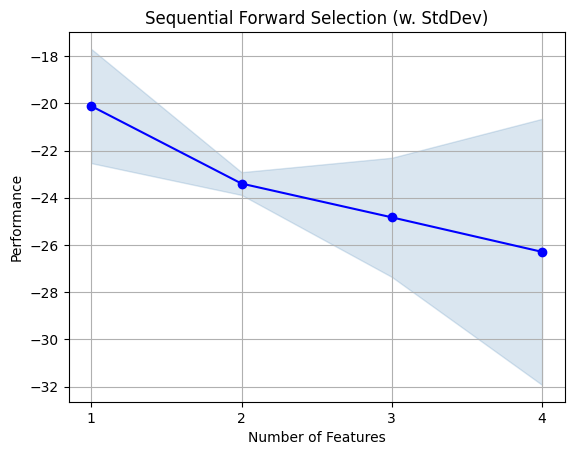

In [49]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

In [50]:
class ColumnExtractor(object):

    def __init__(self, cols):
        self.cols = cols

    def transform(self, X):
        return X[:,self.cols]
    
    def fit(self, X, y=None):
        return self

In [52]:
rfe_sfs_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('rfe_extractor', ColumnExtractor(rfe_sfs_idx)),
    ('model', regressor)
])

rfe_sfs_pipeline.fit(X_train, y_train)

Learning rate set to 0.044577
0:	learn: 13783.0738811	total: 1.09ms	remaining: 1.09s
1:	learn: 13231.4937637	total: 1.68ms	remaining: 839ms
2:	learn: 12712.0591776	total: 2.22ms	remaining: 738ms
3:	learn: 12225.2910855	total: 2.73ms	remaining: 680ms
4:	learn: 11766.0900700	total: 4.04ms	remaining: 804ms
5:	learn: 11324.3576083	total: 4.6ms	remaining: 762ms
6:	learn: 10895.9363312	total: 5.16ms	remaining: 731ms
7:	learn: 10455.3394547	total: 7.2ms	remaining: 892ms
8:	learn: 10034.6571675	total: 7.95ms	remaining: 876ms
9:	learn: 9658.9293933	total: 9.07ms	remaining: 898ms
10:	learn: 9304.7124530	total: 10.4ms	remaining: 935ms
11:	learn: 8934.8402022	total: 12.6ms	remaining: 1.04s
12:	learn: 8589.2919393	total: 14.6ms	remaining: 1.11s
13:	learn: 8289.5262184	total: 15.8ms	remaining: 1.11s
14:	learn: 7982.3441739	total: 16.4ms	remaining: 1.07s
15:	learn: 7690.7989064	total: 16.8ms	remaining: 1.03s
16:	learn: 7396.2143596	total: 17.3ms	remaining: 1s
17:	learn: 7134.6178959	total: 18.6ms	rem

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Annual Income', 'Year',
                                                   'Price/Income',
                                                   'norm_Income',
                                                   'norm_Price']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=99999999),
                                                  ['Gender', 'Dealer_Name',
                                                   'Company', 'Model', 'Color',
                                                   'Dealer_No ', 'Body Style',
                                                   'Dealer_Region',...
                                                  Pipeline(steps=[('poly_features',
                                                                   PolynomialFeatures(include_bias=False)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Year', 'Annual Income']),
                                                 ('kbin',
                                                  KBinsDiscretizer(encode='ordinal',
                                                                   n_bins=3,
                                                                   strategy='uniform'),
                                                  ['Year', 'Annual Income'])])),
                ('rfe_extractor',
                 <__main__.ColumnExtractor object at 0x74b9d2bad570>),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x74b9ea97a980>)])

In [53]:
predictions_sfs = rfe_sfs_pipeline.predict(X_test)

metrics = {}
metrics["mae"] = mean_absolute_error(y_test, predictions_sfs)   
metrics["mape"] = mean_absolute_percentage_error(y_test, predictions_sfs)
metrics["mse"] = mean_squared_error(y_test, predictions_sfs)

metrics


{'mae': 59.637709775198374,
 'mape': 0.0024078204312027135,
 'mse': 13594.068208604578}

In [54]:
RUN_NAME = 'SFS'
with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(rfe_sfs_pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_artifact('rfe_sfs_col.txt')
    mlflow.log_artifact('rfe_sfs_idx.txt')
    mlflow.log_params(model_sklearn.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

2024/11/18 23:40:57 INFO mlflow.tracking._tracking_service.client: 🏃 View run SFS at: http://127.0.0.1:5000/#/experiments/1/runs/66a32de653a843afadb3ed80354e5eac.
2024/11/18 23:40:57 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.


In [56]:
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
import mlflow

def objective(trial):
    # Гиперпараметры для настройки
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    max_features = trial.suggest_float('max_features', 0.1, 1.0)

    # Создаем и обучаем модель
    opt_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, max_features=max_features))
    ])
    
    opt_pipeline.fit(X_train, y_train)

    # Предсказание и расчет метрики MAE
    preds = opt_pipeline.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    return mae  # Минимизируем MAE

# Запускаем оптимизацию
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# Выводим лучшие гиперпараметры
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2024-11-18 23:41:21,999] A new study created in memory with name: no-name-1d80a895-06dc-4c9c-8997-91907439bcf8
[I 2024-11-18 23:41:22,690] Trial 0 finished with value: 375.8248088658443 and parameters: {'n_estimators': 107, 'max_depth': 6, 'max_features': 0.6256244363232181}. Best is trial 0 with value: 375.8248088658443.
[I 2024-11-18 23:41:23,096] Trial 1 finished with value: 215.06052782541514 and parameters: {'n_estimators': 53, 'max_depth': 6, 'max_features': 0.7727215066835916}. Best is trial 1 with value: 215.06052782541514.
[I 2024-11-18 23:41:24,802] Trial 2 finished with value: 83.20467311740026 and parameters: {'n_estimators': 180, 'max_depth': 15, 'max_features': 0.6973689167862641}. Best is trial 2 with value: 83.20467311740026.
[I 2024-11-18 23:41:25,382] Trial 3 finished with value: 1351.5550275860764 and parameters: {'n_estimators': 123, 'max_depth': 3, 'max_features': 0.8881897463209489}. Best is trial 2 with value: 83.20467311740026.
[I 2024-11-18 23:41:26,169] Tri

Number of finished trials: 10
Best trial: {'n_estimators': 139, 'max_depth': 15, 'max_features': 0.9320357500454514}


In [57]:
# Используем оптимальные параметры
best_params = study.best_trial.params
opt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(**best_params))
])

opt_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Annual Income', 'Year',
                                                   'Price/Income',
                                                   'norm_Income',
                                                   'norm_Price']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=99999999),
                                                  ['Gender', 'Dealer_Name',
                                                   'Company', 'Model', 'Color',
                                                   'Dealer_No ', 'Body Style',
                                                   'Dealer_Region', 'Config']),
                                                 ('poly',
                                                  Pipeline(steps=[('poly_features',
                                                                   PolynomialFeatures(include_bias=False)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Year', 'Annual Income']),
                                                 ('kbin',
                                                  KBinsDiscretizer(encode='ordinal',
                                                                   n_bins=3,
                                                                   strategy='uniform'),
                                                  ['Year', 'Annual Income'])])),
                ('model',
                 RandomForestRegressor(max_depth=15,
                                       max_features=0.9320357500454514,
                                       n_estimators=139))])

In [58]:
predictions = opt_pipeline.predict(X_test) 

metrics = {}
metrics["mae"] = mean_absolute_error(y_test, predictions)   
metrics["mape"] = mean_absolute_percentage_error(y_test, predictions)
metrics["mse"] = mean_squared_error(y_test, predictions)

metrics

{'mae': 25.190068923881977,
 'mape': 0.000880528849788951,
 'mse': 7624.659781396604}

In [59]:
RUN_NAME = 'optuna_model'
with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(opt_pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_params(model_sklearn.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

2024/11/18 23:42:11 INFO mlflow.tracking._tracking_service.client: 🏃 View run optuna_model at: http://127.0.0.1:5000/#/experiments/1/runs/b12d9b11f7684540be412db26773c008.
2024/11/18 23:42:11 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.


In [60]:
# Соединяем обратно обучающую и тестовую выборки для признаков и целевой переменной
X_full = pd.concat([X_train, X_test], axis=0)
y_full = pd.concat([y_train, y_test], axis=0)

In [61]:
X_train_sklearn = X_full.copy()

In [65]:
# Выбираем 2-3 числовых признака для создания полиномиальных признаков
numeric_features = ["Year", "Annual Income"]  # Замените на имена числовых признаков
# Определяем трансформации
transformers=[
    ('num', s_scaler, num_features),  # преобразования для числовых признаков
    ('cat', l_encoder, cat_features), # преобразования для категориальных признаков
]
# Полиномиальные признаки
if numeric_features:
    transformers.append(
        ("poly", Pipeline([
            ("poly_features", PolynomialFeatures(degree=2, include_bias=False)),
            ("scaler", StandardScaler())  # Шкалируем полиномиальные признаки
        ]), numeric_features)
    )
# Разбиваем на корзины с использованием KBinsDiscretizer, если временных признаков нет
transformers.append(
    ("kbin", KBinsDiscretizer(n_bins=3, encode="ordinal", strategy="uniform"), numeric_features)
)


In [66]:
# ColumnTransformer для применения трансформаций
preprocessor = ColumnTransformer(transformers=transformers, remainder="passthrough")

# Применяем трансформации к X_train_sklearn
X_train_fe_sklearn = preprocessor.fit_transform(X_train_sklearn)

# Сохраняем имена столбцов
column_names = preprocessor.get_feature_names_out()
pd.DataFrame(column_names).to_csv("column_names_final.csv", index=False)  # Сохраняем в файл



X_transformed_df = pd.DataFrame(X_train_fe_sklearn, columns=preprocessor.get_feature_names_out())


# Шаг 3: Создаем Pipeline для модели
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ('model', regressor)  # Замените на вашу модель
])

In [67]:
final_model = pipeline.fit(X_full, y_full)

Learning rate set to 0.046653
0:	learn: 13433.7237667	total: 6.2ms	remaining: 6.2s
1:	learn: 12912.0252942	total: 9.28ms	remaining: 4.63s
2:	learn: 12367.0689282	total: 12.3ms	remaining: 4.09s
3:	learn: 11896.1638621	total: 15.2ms	remaining: 3.78s
4:	learn: 11425.1519891	total: 19.2ms	remaining: 3.82s
5:	learn: 10987.6719328	total: 23.5ms	remaining: 3.88s
6:	learn: 10555.2848795	total: 26.7ms	remaining: 3.79s
7:	learn: 10122.2278523	total: 31.7ms	remaining: 3.92s
8:	learn: 9721.9242209	total: 36.6ms	remaining: 4.03s
9:	learn: 9356.1474385	total: 39.6ms	remaining: 3.92s
10:	learn: 8978.7968310	total: 42.2ms	remaining: 3.79s
11:	learn: 8664.3311946	total: 45.1ms	remaining: 3.71s
12:	learn: 8335.5198982	total: 53.5ms	remaining: 4.06s
13:	learn: 8005.3466138	total: 56.4ms	remaining: 3.97s
14:	learn: 7705.9121914	total: 60.7ms	remaining: 3.99s
15:	learn: 7431.3682934	total: 62.9ms	remaining: 3.87s
16:	learn: 7168.5206603	total: 64.5ms	remaining: 3.73s
17:	learn: 6887.0478272	total: 67.5ms	r

In [68]:
input_example = X_full.head(5)
RUN_NAME = 'final_model'
with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
        # получаем уникальный идентификатор запуска эксперимента
        run_id = run.info.run_id 
        mlflow.sklearn.log_model(pipeline, 
                                    artifact_path="models",
                                    signature=signature,
                                    input_example=input_example,
                                    pip_requirements=req_file
                                )
        mlflow.log_params(model_sklearn.get_params())
        mlflow.log_artifact("column_names_final.csv", artifact_path="columns")
        
run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

2024/11/18 23:44:36 INFO mlflow.tracking._tracking_service.client: 🏃 View run final_model at: http://127.0.0.1:5000/#/experiments/1/runs/f62f5982a4f441e399fc05092472d00a.
2024/11/18 23:44:36 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.
